<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/naive%20neural%20network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Naive 2-layer Neural Network by Numpy

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparation of Data set (Iris)
data_tr is the training data set with 100 entries and data_te is the test data set with 50 ones.
They will be disordered randomly and divided into 2 groups consisting of data and target.

In [2]:
data = datasets.load_iris().data
target = np.zeros([datasets.load_iris().target.shape[0], 3])
for i in range(datasets.load_iris().target.shape[0]):
  target[i][datasets.load_iris().target[i]] = 1

In [3]:
data = pd.DataFrame(datasets.load_iris().data, columns=list('ABCD'))
data['E'] = datasets.load_iris().target
data_tr = data.sample(n = 100, replace=False)
data_te = data.sample(n = 50, replace=False)
data_tr_data = np.array(data_tr.drop(columns=['E']))
data_tr_label = np.array(data_tr['E'])
data_tr_target = np.zeros([data_tr_label.size, 3])
for i in range(data_tr_label.size):
  data_tr_target[i][data_tr_label[i]] = 1
data_te_data = np.array(data_te.drop(columns=['E']))
data_te_label = np.array(data_te['E'])
data_te_target = np.zeros([data_te_label.size, 3])
for i in range(data_te_label.size):
  data_te_target[i][data_te_label[i]] = 1

# Implementation of 2-Layer Neural Network

In [61]:
class neural_network():
  def __init__(self, input_size, hidden_size, output_size, weight_init=0.1):
    self.w1 = weight_init * np.random.rand(input_size, hidden_size)
    self.b1 = np.zeros(hidden_size)
    self.w2 = weight_init * np.random.rand(hidden_size, output_size)
    self.b2 = np.zeros(output_size)

  def sigmoid(self, x):
    return 1.0 / (1.0 + np.exp(-x))

  def softmax(self, a):
    '''one-dim
    c = np.max(a)
    e_a = np.exp(a-c)
    sum_e_a = np.sum(e_a)
    return e_a / sum_e_a
    '''
    a = a - np.max(a, axis=-1, keepdims=True)
    return np.exp(a) / np.sum(np.exp(a), axis=-1, keepdims=True)

  def forward(self, x):
    a1 = np.dot(x, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2
    y = self.softmax(a2)
    return y

  def cross_entropy_error(self, y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

  def cost_function(self, data, target):
    error_list = [self.cross_entropy_error(self.forward(data[i]), target[i]) for i in range(data.shape[0])]
    return np.sum(np.array(error_list) / data.shape[0])
      
  def gradient(self, data, target):
    h = 1e-4
    grad_w1 = np.zeros_like(self.w1)
    grad_w2 = np.zeros_like(self.w2)
    grad_b1 = np.zeros_like(self.b1)
    grad_b2 = np.zeros_like(self.b2)
    for i in range(self.w1.shape[0]):
      for j in range(self.w1.shape[1]):
        w_ij = self.w1[i][j]
        self.w1[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w1[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w1[i][j] = (y_r-y_l) / (2*h)
        self.w1[i][j] = w_ij
    for i in range(self.w2.shape[0]):
      for j in range(self.w2.shape[1]):
        w_ij = self.w2[i][j]
        self.w2[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w2[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w2[i][j] = (y_r-y_l) / (2*h)
        self.w2[i][j] = w_ij
    for i in range(self.b1.size):
      b_i = self.b1[i]
      self.b1[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b1[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b1[i] = (y_r-y_l) / (2*h)
      self.b1[i] = b_i
    for i in range(self.b2.size):
      b_i = self.b2[i]
      self.b2[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b2[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b2[i] = (y_r-y_l) / (2*h)
      self.b2[i] = b_i
    return grad_w1, grad_w2, grad_b1, grad_b2

  def gradient_backpropagation(self, data, target):
    a1 = np.dot(data, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2

    loss = self.cost_function(data, target)
    error_fw = self.softmax(a2)
    error_softmax = (error_fw-target) / target.shape[0]

    grad_b2 = np.sum(error_softmax, axis=0)
    grad_w2 = np.dot(z1.T, error_softmax)

    error_l2 = np.dot(error_softmax, self.w2.T)
    error_sigmoid = error_l2*(1.-z1)*z1

    grad_b1 = np.sum(error_sigmoid, axis=0)
    grad_w1 = np.dot(data.T, error_sigmoid)

    return grad_w1, grad_w2, grad_b1, grad_b2

  def train(self, data, target, learning_rate = 0.01, times = 100):
    error = np.zeros(times)
    for i in range(times):
      grad_w1, grad_w2, grad_b1, grad_b2 = self.gradient(data, target)
      self.w1 -= learning_rate * grad_w1
      self.w2 -= learning_rate * grad_w2
      self.b1 -= learning_rate * grad_b1
      self.b2 -= learning_rate * grad_b2
      error[i] = self.cost_function(data, target)
    return error

  def recognize(self, x):
    return np.argmax(self.forward(x))

# Training and Testing

In [62]:
nn = neural_network(4, 10, 3)
error = nn.train(data_tr_data, data_tr_target, 0.3, 500)

In [63]:
correct = 0
for i in range(50):
  if data_te_target[i][nn.recognize(data_te_data[i])] == 1:
    correct += 1
print("Accuracy: {:.2%}".format(correct / 50))

Accuracy: 96.00%


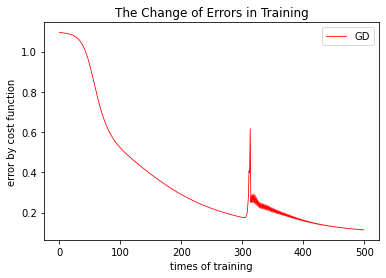

In [64]:
times = np.arange(0, 500, 1)
plt.figure("Training of naive neural network")
plt.title("The Change of Errors in Training")
plt.xlabel("times of training")
plt.ylabel("error by cost function")
plt.plot(times, error, 'r', label='GD', linewidth=0.8)
plt.legend()